## Load packages and  the clean training and  test sets

In [2]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm, tqdm_notebook

import funCleaning, funEDA, funChurn

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, StratifiedShuffleSplit, learning_curve
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import make_scorer, fbeta_score, average_precision_score,  roc_curve, roc_auc_score, precision_recall_curve
# from sklearn.base import BaseEstimator, TransformerMixin  # to create custom transformers
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# display all columns of df
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 80

In [6]:
# load training and test sets generated at the beginning of EDA ipynb
trainSet = pd.read_csv('churnTrainSet.csv', low_memory=False)
testSet = pd.read_csv('churnTestSet.csv', low_memory=False)

## Perform cleaning functions defined in EDA-Notebook

(but not yet the outlier and NaN removal)

In [7]:
# load lists with columns to delete, dtypes to fix, columns to log-transform (stored in EDA ipynb)
%store -r colsToDel
%store -r colsToCat
%store -r colsToLog10

In [10]:
# disable warning
pd.set_option('mode.chained_assignment', None)

# create pipeline to clean training set with same functions as used / defined in EDA notebook
trainSet = (trainSet
 .pipe(funCleaning.fixDtypes, colsToCat=colsToCat)
 .pipe(funChurn.funCleanNumericals)
 .pipe(funCleaning.colsToLog10, colsToLog10=colsToLog10)
 .pipe(funChurn.funCleanCategoricals)
 .pipe(funChurn.funCleanStrings)
 .pipe(funChurn.funCleanMissingStates)
 .pipe(funCleaning.delCols, colsToDel=colsToDel)
);

'car_nr successfully deleted'

'ref_dt successfully deleted'

'ACCIDENT_CAR successfully deleted'

'DESCRIPTION_DE successfully deleted'

'DESCRIPTION_DE2 successfully deleted'

'BUDGET_TYPE_IMPORT successfully deleted'

'SALES_TYPE_IMPORT successfully deleted'

'FUNCTION_TYPE_UID successfully deleted'

'TITLE successfully deleted'

'POSITION successfully deleted'

'EVT_BIRTH successfully deleted'

'NAME successfully deleted'

'PERSON_CITY successfully deleted'

'SECTOR_UID successfully deleted'

'IS_RETAIL_PARTNER successfully deleted'

'IS_SERVICE_PARTNER successfully deleted'

'RATING_UID successfully deleted'

'PARTNER_ADRESS_TYPE_UID successfully deleted'

'Altersklasse5J successfully deleted'

'Kanton successfully deleted'

'CAR_OWNER_JOIN_NR successfully deleted'

'WEMFWirtschaftsgebiet successfully deleted'

'PERSON_STREET successfully deleted'

'PERSON_ZIP_CODE successfully deleted'

'PARTNER_STREET successfully deleted'

'PARTNER_ZIP_CODE successfully deleted'

'PARTNER_LAT successfully deleted'

'PARTNER_LNG successfully deleted'

'PARTNER_ADDRESS successfully deleted'

'PARTNER_COMPANY_NR successfully deleted'

'Sprachregion successfully deleted'

'SUM_INVOICE_AMOUNT_IN_SERVICE successfully deleted'

'Altersklasse1J successfully deleted'

'dist_seconds successfully deleted'

'ACTIVE successfully deleted'

'KANTON_LICENCE_PLATE successfully deleted'

'LAST_EVT successfully deleted'

'FIRST_EVT successfully deleted'

'EXTERIOR_COLOR_DE successfully deleted'

'INTERIOR_COLOR_DE successfully deleted'

In [11]:
#check
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41610 entries, 0 to 45421
Data columns (total 42 columns):
target_event               41610 non-null int64
NUM_CONSEC_SERVICES        41610 non-null int64
SUM_INVOICE_AMOUNT_log     29776 non-null float64
NUM_EVENTS_log             41610 non-null float64
LAST_MILEAGE_log           41610 non-null float64
MEAN_MILEAGE_PER_MNTH      41610 non-null float64
AVG_DIFF_MNTH              41610 non-null int64
age_mnth                   41610 non-null int64
INSPECTION_INTERVAL_UID    41610 non-null category
LIST_PRICE_log             41609 non-null float64
END_CUSTOMER_STATUS_UID    41609 non-null category
CAR_BRAND_UID              41610 non-null category
FUEL_TYPE_UID              41609 non-null category
GEAR_TYPE_UID              41609 non-null category
WHEEL_DRIVE_UID            41609 non-null category
NUMBER_OF_DOORS_UID        40758 non-null category
GEAR_COUNT                 41609 non-null category
BASE_MARGIN                41610 non-null

## Remove NaN and outliers from training set

In [12]:
# remove NaN
colsToImputeNum = ['ownerAge', 'SUM_INVOICE_AMOUNT_log']
colsToImputeCat = ['NUMBER_OF_DOORS_UID']
colsToDrop = ['Haushaltstyp', 'Urbanitaet', 'Wohneigentumverhaeltnis', 'Haushaltsgroesse', 'KaufkraftindexGemeinde', 
             'Fahrzeugtyp', 'Haushaltseinkommen', 'Fahrzeugklasse', 'Lebensphase', 'HaushaltsgroesseFein', 'Fahrzeugart']

trainSet = funCleaning.nanRemoval(trainSet, dropAll=True, colsToImputeNum=colsToImputeNum, 
                                  colsToImputeCat=colsToImputeCat, colsToDrop=colsToDrop)


'ownerAge - median value to impute: 49.0'

'SUM_INVOICE_AMOUNT_log - median value to impute: 2.9860772029124125'

'NUMBER_OF_DOORS_UID - most frequent value to impute: 5.0'

In [13]:
# remove Outliers
trainSet = funCleaning.outlierRemovalIQR(trainSet, dist=1.5);

target_event
Outliers removed: 0

NUM_CONSEC_SERVICES
Outliers removed: 376

SUM_INVOICE_AMOUNT_log
Outliers removed: 3300

NUM_EVENTS_log
Outliers removed: 9

LAST_MILEAGE_log
Outliers removed: 598

MEAN_MILEAGE_PER_MNTH
Outliers removed: 1117

AVG_DIFF_MNTH
Outliers removed: 867

age_mnth
Outliers removed: 0

LIST_PRICE_log
Outliers removed: 175

ownerAge
Outliers removed: 30

dist_metres_log
Outliers removed: 317



In [14]:
# remove categorical values that are not found in both sets (to make sure one-hot-encoding returns same number of cols)
len1 = len(trainSet)
trainSet = trainSet[trainSet['BASE_MARGIN'] != '7.2'] 
trainSet = trainSet[trainSet['FUEL_TYPE_UID'] != 'Elektro'] 
trainSet = trainSet[trainSet['FUEL_TYPE_UID'] != 'Plugin Hybrid Benzin']
trainSet = trainSet[trainSet['SALES_TYPE'] != 'Praktik']
trainSet = trainSet[trainSet['SALES_TYPE'] != 'e-up!']
len2 = len(trainSet)
print("Rows removed: {}".format(len1-len2))

Rows removed: 3


In [15]:
#check
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34683 entries, 0 to 45419
Data columns (total 31 columns):
target_event               34683 non-null int64
NUM_CONSEC_SERVICES        34683 non-null int64
SUM_INVOICE_AMOUNT_log     34683 non-null float64
NUM_EVENTS_log             34683 non-null float64
LAST_MILEAGE_log           34683 non-null float64
MEAN_MILEAGE_PER_MNTH      34683 non-null float64
AVG_DIFF_MNTH              34683 non-null int64
age_mnth                   34683 non-null int64
INSPECTION_INTERVAL_UID    34683 non-null category
LIST_PRICE_log             34683 non-null float64
END_CUSTOMER_STATUS_UID    34683 non-null category
CAR_BRAND_UID              34683 non-null category
FUEL_TYPE_UID              34683 non-null category
GEAR_TYPE_UID              34683 non-null category
WHEEL_DRIVE_UID            34683 non-null category
NUMBER_OF_DOORS_UID        34683 non-null category
GEAR_COUNT                 34683 non-null category
BASE_MARGIN                34683 non-null

## Separate predictors from labels

In [16]:
train = trainSet.drop('target_event', axis=1)  # note: .drop() creates a copy and does not affect trainSet
trainLabels = trainSet['target_event'].copy()

## Perform Preprocessing with Scikit-Learn Pipeline

In [17]:
df = train
numCols = list(df.select_dtypes(include = ['float64', 'int64']).columns)
catCols = list(df.select_dtypes(include = 'category').columns)

# make sure every value in all of the two column groups is of the same dtype for the encoding
for col in numCols:
    df[col] = df[col].astype(float) 
for col in catCols:
    df[col] = df[col].astype(str)

# pipeline for standardization and one-hot-encoding
fullPipeline = ColumnTransformer([
        ('std_scaler', StandardScaler(), numCols),
        ('encoder', OneHotEncoder(), catCols),
    ])

train_prepared = fullPipeline.fit_transform(df)

In [18]:
# check
train_prepared

<34683x228 sparse matrix of type '<class 'numpy.float64'>'
	with 1040490 stored elements in Compressed Sparse Row format>

## Test promising models


Train different models 'quick and dirty' and validate with stratified k-fold cross validation. Models are:
- LogisticRegression 
- GaussianNB (Naïve Bayes) 
- KNeighborsClassifier 
- SVC 
- RandomForestClassifier 
- XGBClassifier

In [175]:
# initialize the defined models
classifiers = [
    LogisticRegression(solver='liblinear'),
    KNeighborsClassifier(3), # testscore of 76% with n=5, 74% with n=1
    SVC(gamma='auto'), # parameter "probability=True" will only be set for final run to speed things up
    GaussianNB(),
    RandomForestClassifier(n_estimators=10),
    GradientBoostingClassifier(n_estimators=100),
    ]

In [176]:
# for each model, fit to train set and validate with stratified 5-fold cross validation, store results in a nested dict
# cross_validate returns a dict with 'fit_time', 'score_time', 'test_score' for each run and each model
results = {}
for clf in tqdm(classifiers):
    try:
        clfName = clf.__class__.__name__
        scores = cross_validate(clf, train_prepared, trainLabels, cv=StratifiedKFold(5), error_score='raise',
                                scoring=make_scorer(fbeta_score, beta=0.5), return_train_score=False, return_estimator=True)
    except:  # exception for classifiers that need an array as input (GaussianNB)
        clfName = clf.__class__.__name__ 
        scores = cross_validate(GaussianNB(), train_prepared.toarray(), trainLabels, cv=StratifiedKFold(5), 
                        scoring=make_scorer(fbeta_score, beta=0.5), return_train_score=False, return_estimator=True)
    results[clfName] = scores

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [12:36<00:00, 88.03s/it]


In [17]:
# define and call a function for storage of cv results in df 'longlistResults'
def cvResultsDF(cvDict):
    """Store results of CV in Dataframe, including columns for 95% confidence interval for test score and mean test score."""
    df = pd.DataFrame(cvDict).transpose()
    df['95_conf'] = df['test_score'].apply(lambda x: np.std(x) * 2)
    for col in df.iloc[:,1:]:
        df[col] = df[col].apply(lambda x: np.mean(x))
    df['total_time'] = df['score_time'] + df['fit_time']
    return df

longlistResults = cvResultsDF(results)

In [18]:
#check the results
longlistResults

,estimator,fit_time,score_time,test_score,95_conf,total_time
LogisticRegression,"(LogisticRegression(C=1.0, class_weight=None, ...",1.050288,0.006248,0.802217,0.005951,1.056537
KNeighborsClassifier,"(KNeighborsClassifier(algorithm='auto', leaf_s...",0.014563,12.625543,0.741632,0.005374,12.640106
SVC,"(SVC(C=1.0, cache_size=200, class_weight=None,...",106.096052,17.379157,0.818011,0.005054,123.475209
GaussianNB,"(GaussianNB(priors=None, var_smoothing=1e-09),...",0.164748,0.046482,0.378644,0.217364,0.211230
RandomForestClassifier,"((DecisionTreeClassifier(class_weight=None, cr...",4.568505,0.025736,0.771383,0.006416,4.594241
GradientBoostingClassifier,(([DecisionTreeRegressor(criterion='friedman_m...,9.772064,0.024148,0.801017,0.002576,9.796212


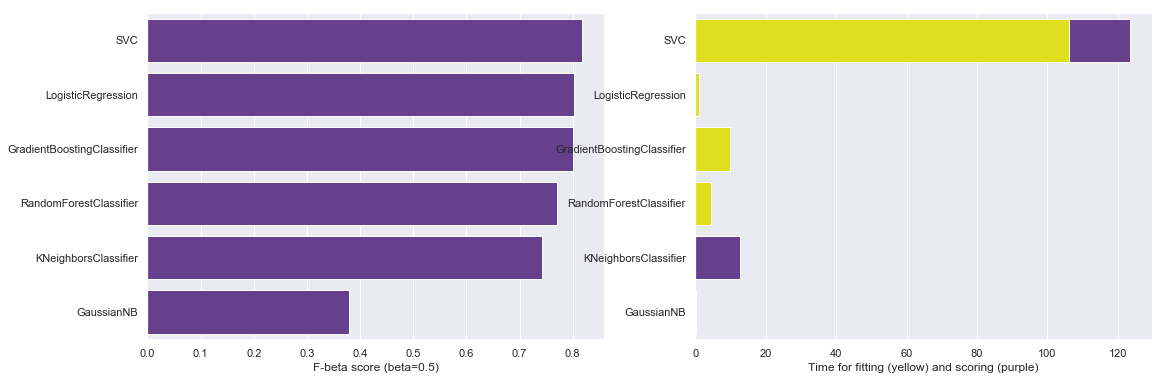

In [19]:
# define and call a function for plotting a comparision of F-beta scores and run times
def cvResultsPlot(resultsDF):
    """Generates a plot of the test scores and run times for CV of different models."""
    data = resultsDF.sort_values(by='test_score', ascending=False)
    plt.figure(figsize=(18,6));
    plt.subplot(1,2,1)
    # plot the mean test scores
    sns.barplot(x='test_score', y=data.index, data=data, color="rebeccapurple")
    plt.xlabel("F-beta score (beta=0.5)");
    plt.subplot(1,2,2)
    # Plot the mean total time
    sns.set_color_codes("pastel")
    sns.barplot(x="total_time", y=data.index, data=data,
        label="Total", color="rebeccapurple")
    # Plot the mean fit time
    sns.set_color_codes("muted")
    sns.barplot(x='fit_time', y=data.index, data=data,
        label="Fit", color="yellow")
    plt.xlabel("Time for fitting (yellow) and scoring (purple)");
    
cvResultsPlot(longlistResults)

**Conclusions:**

- Three top models are SVC (unfortunately the slowest model by far), LogReg and XGB. They make it on the shortlist and will be finetuned further.
- Before Grid Search / Random Search is applied on them I will first look at feature importances and check if it makes sense to reduce dimensionality with help of PCA.

In [178]:
# create shortlist of top-performing models for further tuning
shortlist = [
    LogisticRegression(solver='liblinear'),
    SVC(gamma='auto'),
    GradientBoostingClassifier(n_estimators=100),
    ]

## Foray: Inspect feature importance (explored with XGB classifier)

In [21]:
# fit XGB to training data and print feature importances
xgb = GradientBoostingClassifier(n_estimators=100)
xgb.fit(train_prepared, trainLabels)
xgbImportances = xgb.feature_importances_
print(xgbImportances)

[6.30075672e-02 2.28065113e-02 8.19335107e-02 5.59856236e-02
 7.36202488e-02 4.41346509e-02 4.45523732e-01 4.90573941e-03
 2.29295147e-02 9.80030281e-02 5.81426833e-03 4.89343484e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.08908270e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.04430379e-06
 1.63036443e-04 0.00000000e+00 0.00000000e+00 1.24437562e-04
 0.00000000e+00 0.00000000e+00 5.10969942e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.30740074e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [22]:
# reconstruct feature names (numCols) & one-hot-encoded-attribute names (catCols) for dimensions in training_prepared
encoder = fullPipeline.named_transformers_['encoder']
oneHotAttribs = []
for sublist in list(encoder.categories_):
    for item in sublist:
        oneHotAttribs.append(item)
attribs = numCols + oneHotAttribs
# zip names and importances, print list of tuples
featureImportances = (sorted(zip(xgbImportances, attribs), reverse=True))
featureImportances

[(0.44552373247853677, 'age_mnth'),
 (0.09800302813141072, 'dist_metres_log'),
 (0.08193351074070018, 'NUM_EVENTS_log'),
 (0.07362024883288054, 'MEAN_MILEAGE_PER_MNTH'),
 (0.06300756718838191, 'NUM_CONSEC_SERVICES'),
 (0.05598562361289879, 'LAST_MILEAGE_log'),
 (0.05089082703518586, 'Audi'),
 (0.04413465092520833, 'AVG_DIFF_MNTH'),
 (0.022929514707036695, 'ownerAge'),
 (0.02280651126564608, 'SUM_INVOICE_AMOUNT_log'),
 (0.007153117994001276, '1.0'),
 (0.0058142683255315766, '12 Monate'),
 (0.004905739410608908, 'LIST_PRICE_log'),
 (0.004893434844127614, '24 Monate'),
 (0.00465102010895125, 'Deutsch'),
 (0.002329191272032573, '2.0'),
 (0.0023074007422643076, '7.0'),
 (0.0022797851220730464, 'VS'),
 (0.0015367695143071354, 'Genferseeregion'),
 (0.0011688728547276674, 'Französisch'),
 (0.0006123610347877214, 'BE'),
 (0.0006033763672793787, 'BL'),
 (0.0005109699416284386, '3.0'),
 (0.00038939504039669283, '3'),
 (0.0003867123348738666, 'Französisch'),
 (0.0003841273648202553, 'FR'),
 (0.000

In [23]:
# extract weights from tuples by flattening the list of tuples
weights = np.array([x[0] for x in featureImportances])
# print number of features / attributes for given threshold
print("Features / Attributes total: {}".format(len(weights)))
print("Features / Attributes with weight > 0: {}".format(len(weights[weights > 0])))
print("Features / Attributes with weight > 0.001: {}".format(len(weights[weights > 0.001])))
print("Features / Attributes with weight > 0.005: {}".format(len(weights[weights > 0.005])))

Features / Attributes total: 235
Features / Attributes with weight > 0: 37
Features / Attributes with weight > 0.001: 20
Features / Attributes with weight > 0.005: 12


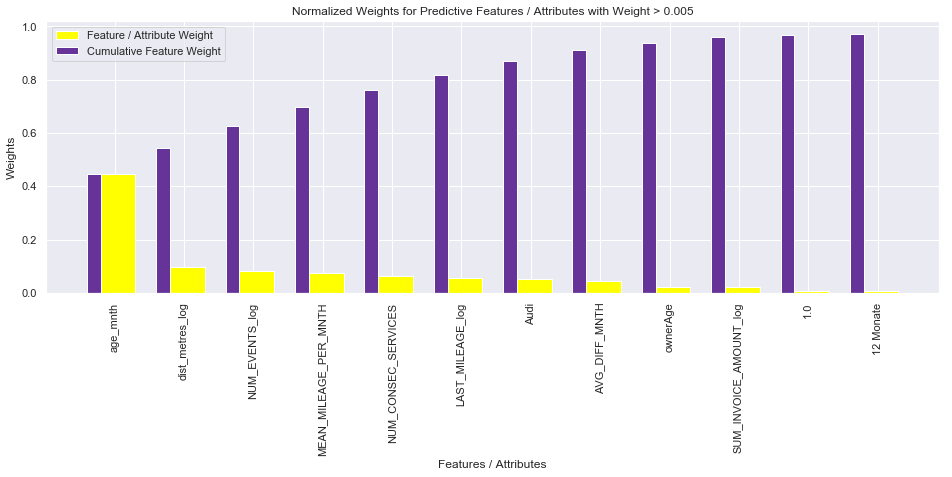

In [24]:
# create dataframe of featureImportances and 
dfPlot = pd.DataFrame(featureImportances)
dfPlot = dfPlot[dfPlot[0] > 0.005]    
# plot features / attributes with biggest weight
fig = plt.figure(figsize = (16,5))
plt.bar(np.arange(len(dfPlot)), dfPlot[0], width = 0.6, align="center", color = 'yellow', \
      label = "Feature / Attribute Weight")
plt.bar(np.arange(len(dfPlot)) - 0.3, np.cumsum(dfPlot[0]), width = 0.2, align = "center", color = 'rebeccapurple', \
      label = "Cumulative Feature Weight")
# styling
plt.title("Normalized Weights for Predictive Features / Attributes with Weight > 0.005", fontsize = 12)
plt.ylabel("Weights", fontsize = 12)
plt.xlabel("Features / Attributes", fontsize = 12)
plt.xticks(np.arange(len(dfPlot)), dfPlot[1], rotation=90)
plt.legend(loc = 'upper left');

**Observations:**
- No suprises here, this is about what was to expect after the EDA. But it is intersting to see how much the numeric features dominate this list of high feature weights (9 out of the top 12).

### Experiment with feature selection

In [25]:
# validate performance of shortlisted models for reduced training set (with given threshold for feature importance)
threshold = 0.01

shortlistResults = {}
for clf in tqdm(shortlist):
    clfName = clf.__class__.__name__
   
    shortPipeline = Pipeline([
      ('feature_selection', SelectFromModel(xgb, threshold=threshold)),
      ('classification', clf)
    ])
 
    scores = cross_validate(shortPipeline, train_prepared, trainLabels, cv=StratifiedKFold(5), 
                                     scoring=make_scorer(fbeta_score, beta=0.5), return_train_score=False, return_estimator=True)
    shortlistResults[clfName] = scores

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:11<00:00, 99.54s/it]


In [30]:
# transform shortlistResults to dataframe and display it
shortlistResults = cvResultsDF(shortlistResults)
shortlistResults

,estimator,fit_time,score_time,test_score,95_conf,total_time
LogisticRegression,"(Pipeline(memory=None,\n steps=[('feature_...",9.977327,0.004388,0.795688,0.002604,9.981716
SVC,"(Pipeline(memory=None,\n steps=[('feature_...",44.739839,3.018642,0.830491,0.004819,47.758481
GradientBoostingClassifier,"(Pipeline(memory=None,\n steps=[('feature_...",16.572344,0.023148,0.801308,0.003396,16.595492


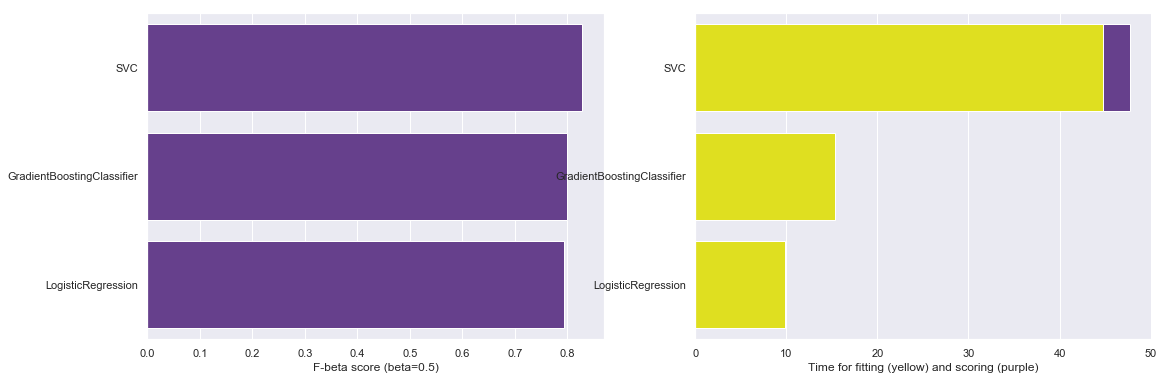

In [29]:
# plot the shortlistResults
cvResultsPlot(shortlistResults)

**Observations:**

- A reduction from 231 to 20 features results in a slightly better score for the SVC-model (and halfed runtime).
- The scores for LogReg and XGB are nearly the same as before / very slightly reduced.

In the next step I will test the effect of different thresholds for the three models separately:

In [32]:
# check and display LogReg score for different thresholds 
print("LogReg:\nMean F-beta score without feature elimination: {:.2f}".format(float(longlistResults.iloc[0,3])*100))
thresholds = [0.00000001, 0.001, 0.005, 0.01, 0.05]

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    selected_train = selection.transform(train_prepared)
    # evaluate model with 5-fold CV
    scores_selected = cross_validate(shortlist[0], selected_train, trainLabels,cv=StratifiedKFold(5), 
                                     scoring=make_scorer(fbeta_score, beta=0.5), return_train_score=False)
    print("Thresh={:.3f}, n={}, mean F-beta score: {:.2f}".format(thresh, selected_train.shape[1], 
                                                            np.mean(scores_selected['test_score'])* 100.0))

LogReg:
Mean F-beta score without feature elimination: 80.22
Thresh=0.000, n=37, mean F-beta score: 79.89
Thresh=0.001, n=20, mean F-beta score: 79.84
Thresh=0.005, n=12, mean F-beta score: 79.85
Thresh=0.010, n=10, mean F-beta score: 79.57
Thresh=0.050, n=7, mean F-beta score: 78.76


In [35]:
# check and display SVC score for different thresholds 
print("SVC:\nMean F-beta score without feature elimination: {:.2f}".format(float(longlistResults.iloc[2,3])*100))
thresholds = [0.00000001, 0.001, 0.005, 0.01, 0.05]

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    selected_train = selection.transform(train_prepared)
    # evaluate model with 5-fold CV
    scores_selected = cross_validate(shortlist[1], selected_train, trainLabels,cv=StratifiedKFold(5), 
                                     scoring=make_scorer(fbeta_score, beta=0.5), return_train_score=False)
    print("Thresh={:.3f}, n={}, mean F-beta score: {:.2f}".format(thresh, selected_train.shape[1], 
                                                            np.mean(scores_selected['test_score'])* 100.0))

SVC:
Mean F-beta score without feature elimination: 81.80
Thresh=0.000, n=37, mean F-beta score: 83.22
Thresh=0.001, n=20, mean F-beta score: 83.14
Thresh=0.005, n=12, mean F-beta score: 83.03
Thresh=0.010, n=10, mean F-beta score: 83.05
Thresh=0.050, n=7, mean F-beta score: 83.16


In [33]:
# check and display XGB score for different thresholds 
print("XGB:\nMean F-beta score without feature elimination: {:.2f}".format(float(longlistResults.iloc[5,3])*100))
thresholds = [0.00000001, 0.001, 0.005, 0.01, 0.05]

for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    selected_train = selection.transform(train_prepared)
    # evaluate model with 5-fold CV
    scores_selected = cross_validate(shortlist[2], selected_train, trainLabels,cv=StratifiedKFold(5), 
                                     scoring=make_scorer(fbeta_score, beta=0.5), return_train_score=False)
    print("Thresh={:.3f}, n={}, mean F-beta score: {:.2f}".format(thresh, selected_train.shape[1], 
                                                            np.mean(scores_selected['test_score'])* 100.0))

XGB:
Mean F-beta score without feature elimination: 80.10
Thresh=0.000, n=37, mean F-beta score: 80.20
Thresh=0.001, n=20, mean F-beta score: 80.27
Thresh=0.005, n=12, mean F-beta score: 80.20
Thresh=0.010, n=10, mean F-beta score: 80.13
Thresh=0.050, n=7, mean F-beta score: 79.60


**Observations:**

- XGB (a little bit) and especially SVC both score higher when only features with weight > 0 (--> 29 features) are kept. However a further reduction in the number of features also reduces the score for both models slightly - exception: it is higher again for SVC only when there are only seven features left.

Because Feature Importance cannot be automatically applied to the data sets, a dimensionality reduction with PCA will be tested in the next step.

## Apply dimensionality reduction with PCA

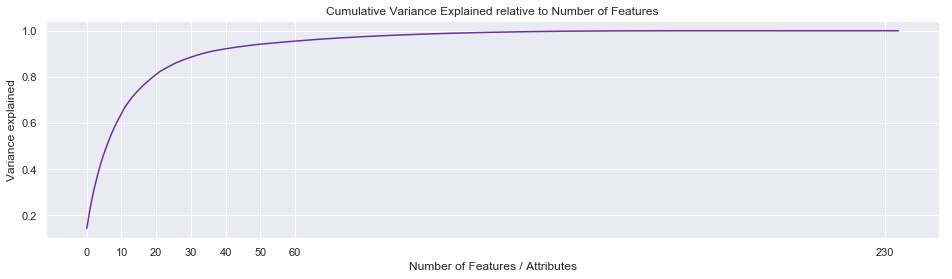

In [38]:
# fit PCA to training set
pca = PCA()
pca.fit(train_prepared.toarray())
# plot cumulative explained variance curve
varSum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(16,4))
sns.lineplot(data=varSum, color='rebeccapurple');
plt.xticks([0, 10, 20, 30, 40, 50, 60, 230])
plt.title("Cumulative Variance Explained relative to Number of Features", fontsize = 12)
plt.ylabel("Variance explained", fontsize = 12)
plt.xlabel("Number of Features / Attributes", fontsize = 12);

In [180]:
# create pipeline with CV to check some params for PCA that optimize results of SVC and XGB 
dimPipe = Pipeline([
    ('reduce_dim', PCA()), 
    ('classify', shortlist[1])]
)                                        
n_components_options = [0.94, 0.96]
whiten_options = [True, False]
param_grid = [
    {
        'reduce_dim__n_components': n_components_options,
        'reduce_dim__whiten': whiten_options,
        'classify': [shortlist[1], shortlist[2]]
    },
]
# reduced to cv=3 to save some time
grid = GridSearchCV(dimPipe, cv=3, n_jobs=1, param_grid=param_grid, scoring=make_scorer(fbeta_score, beta=0.5))
grid.fit(train_prepared.toarray(), trainLabels)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'reduce_dim__n_components': [0.94, 0.96], 'reduce_dim__whiten': [True, False], 'classify': [SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True...   subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_sco

In [184]:
# display the results
display(grid.best_estimator_)
display(grid.best_score_)
print("Mean test scores for SVC: {}".format(grid.cv_results_['mean_test_score'][:4]))
print("Mean test scores for XGB: {}".format(grid.cv_results_['mean_test_score'][4:]))

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=0.96, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

0.8285488979998528

Mean test scores for SVC: [0.81736675 0.82771607 0.81306137 0.8285489 ]
Mean test scores for XGB: [0.79663369 0.79662018 0.79760511 0.79762899]


In [15]:
# as SVC profits more from PCA than XGB: check if PCA with retained variance of 0.97 is even better for SVC only
pca97 = PCA(n_components = 0.97)
train_reduced_97 = pca97.fit_transform(train_prepared.toarray())
# print number of components
len(pca97.explained_variance_ratio_)

76

In [79]:
# calculate mean test scores for SVC and PCA with 0.97 of original variance
tempScores = cross_validate(shortlist[1], train_reduced_97, trainLabels, cv=StratifiedKFold(5), 
                                 scoring=make_scorer(fbeta_score, beta=0.5), return_train_score=False, return_estimator=True)

In [83]:
# show result
np.mean(tempScores['test_score'])

0.8306965939655765

In [84]:
# check if PCA with retained variance of 0.98 is even better for SVC only
pca98 = PCA(n_components = 0.98)
train_reduced_98 = pca98.fit_transform(train_prepared.toarray())
# print number of components
len(pca98.explained_variance_ratio_)

89

In [85]:
# calculate mean test scores for SVC and PCA with 0.98 of original variance
tempScores = cross_validate(shortlist[1], train_reduced_98, trainLabels, cv=StratifiedKFold(5), 
                                 scoring=make_scorer(fbeta_score, beta=0.5), return_train_score=False, return_estimator=True)

In [86]:
# show result
np.mean(tempScores['test_score'])

0.8294904931280058

**Observations / conclusion:**
- SVC scoring peaks when a PCA is applied that retains 97% of the original variance, which means a reduction to 76 components
- The best score for SVC is only nearly as high as when Feature Reduction is applied, but PCA has the big advantage that it can automatically applied to the test set too.

For finetuning of the 3 remaining models I will use:
 - PCA 97% for SVC
 - no dimensionality reduction for LogReg and XGB as they don't  seem to gain (much) from it

## Finetuning of shortlisted models (Grid search)

In [96]:
# gridsearch for LogReg - fit to training set without dimensionality reduction
logReg = LogisticRegression()
param_grid = {'solver':['liblinear', 'saga'], 'C': [100.0, 200.0, 500.0]}
grid = GridSearchCV(logReg, cv=StratifiedKFold(5), param_grid=param_grid, scoring=make_scorer(fbeta_score, beta=0.5), verbose=10)
logRegGrid = grid.fit(train_prepared, trainLabels)

C:\Users\r2d4\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [102]:
# display the best estimator and best score
print("LogReg:")
display(logRegGrid.best_estimator_)
print("Best mean test score: {:.2f}".format(logRegGrid.best_score_*100))

LogReg:


LogisticRegression(C=500.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

Best mean test score: 80.26


In [103]:
# gridsearch for XGB - fit to training set without dimensionality reduction
xgb = GradientBoostingClassifier()
param_grid = {'n_estimators':[200, 500, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth' : [3, 6]}
grid = GridSearchCV(xgb, cv=StratifiedKFold(5), param_grid=param_grid, scoring=make_scorer(fbeta_score, beta=0.5), verbose=10)
xgbGrid = grid.fit(train_prepared, trainLabels)

In [30]:
# display the best estimator and best score
print("XGB:")
display(xgbGrid.best_estimator_)
print("Best mean test score: {:.2f}".format(xgbGrid.best_score_*100))

XGB:


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Best mean test score: 83.88


In [27]:
# gridsearch for SVC - fit to training set with PCA applied
svc = SVC()
param_grid = [
        {'kernel': ['poly'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10, 100],
         'gamma': [0.001, 0.01, 0.1]},
    ]
grid = GridSearchCV(svc, cv=StratifiedKFold(5), param_grid=param_grid, scoring=make_scorer(fbeta_score, beta=0.5), verbose=10)
svcGrid = grid.fit(train_reduced_97, trainLabels)

In [26]:
# display the best estimator and best score
display("SVC:")
display(svcGrid.best_estimator_)
display("Best mean test score: {}".format(svcGrid.best_score_*100))

'SVC:'

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

'Best mean test score: 83.58716636384699'

**Conclusion:** After finetuning a more complex version of XGB has narrowly overtaken SVC. So this model will be used for the final steps of this project. 

But first I will check that the variance / complexity of the model is not too high and the model does not overfit:

## Validate and fit best model XGB

In [20]:
# initialize best model as xgbChurn
xgbChurn = GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.05, loss='deviance', max_depth=6,
                                      max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                      min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, 
                                      min_weight_fraction_leaf=0.0, n_estimators=1000, n_iter_no_change=None, presort='auto', 
                                      random_state=None, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=1, 
                                      warm_start=False)

### Validate learning curves

In [ ]:
# apply sklearns learning_curve utility on training set with 3-fold CV
N, trainCurve, valCurve = learning_curve(xgbChurn, train_prepared, trainLabels, cv=StratifiedKFold(3), 
                                         scoring=make_scorer(fbeta_score, beta=0.5), train_sizes=np.linspace(0.01,1.0,20),
                                         n_jobs=-1, verbose=10)

[learning_curve] Training set sizes: [  231  1435  2640  3845  5050  6255  7459  8664  9869 11074 12278 13483
 14688 15893 17098 18302 19507 20712 21917 23122]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  60 | elapsed:  1.2min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done  12 out of  60 | elapsed:  6.2min remaining: 24.8min
[Parallel(n_jobs=-1)]: Done  19 out of  60 | elapsed: 12.2min remaining: 26.3min
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed: 16.5min remaining: 21.5min
[Parallel(n_jobs=-1)]: Done  33 out of  60 | elapsed: 21.9min remaining: 18.0min
[Parallel(n_jobs=-1)]: Done  40 out of  60 | elapsed: 28.4min remaining: 14.2min
[Parallel(n_jobs=-1)]: Done  47 out of  60 | elapsed: 32.1min remaining:  8.9min


In [3]:
# calculate means and std deviation
trainCurveMean = np.mean(trainCurve, axis=1)
valCurveMean = np.mean(valCurve, axis=1)
trainCurveStd = np.std(trainCurve, axis=1)
valCurveStd = np.std(valCurve, axis=1)
# plot learning curves
plt.figure(figsize=(16,4))
plt.plot(N, trainCurveMean, color='rebeccapurple', marker='o', label='training score')
plt.plot(N, valCurveMean, color='yellow', marker='o', label='validation score')
plt.fill_between(N, trainCurveMean - trainCurveStd,trainCurveMean + trainCurveStd, alpha=0.2, color="rebeccapurple")
plt.fill_between(N, valCurveMean - valCurveStd, valCurveMean + valCurveStd, alpha=0.2, color="yellow")
plt.hlines(np.mean([trainCurveMean[-1], valCurveMean[-1]]), N[0], N[-1], color='black', linestyle='dashed')
# styling
plt.ylim(0,1)
plt.xlim(N[0], N[-1])
plt.xlabel('training size')
plt.ylabel('score')
plt.title("Learning Curves F-Beta-Score (beta=0.5)")
plt.legend(loc='lower right');

NameError: name 'trainCurve' is not defined

In [30]:
# check if early stopping is an option
xgbChurnES = GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.05, loss='deviance', max_depth=6,
                                      max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                      min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, 
                                      min_weight_fraction_leaf=0.0, n_estimators=1000, n_iter_no_change=25, presort='auto', 
                                      random_state=None, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=1, 
                                      warm_start=False)

In [31]:
xgbChurnES.fit(train_prepared, trainLabels)

      Iter       Train Loss   Remaining Time 
         1           1.2342            6.27m
         2           1.2173            5.97m
         3           1.2010            5.82m
         4           1.1864            5.77m
         5           1.1731            5.70m
         6           1.1600            5.70m
         7           1.1485            5.65m
         8           1.1372            5.59m
         9           1.1261            5.61m
        10           1.1155            5.57m
        20           1.0341            5.60m
        30           0.9771            5.53m
        40           0.9308            5.53m
        50           0.8987            5.51m
        60           0.8767            5.39m
        70           0.8563            5.31m
        80           0.8388            5.19m
        90           0.8210            5.12m
       100           0.8066            5.04m
       200           0.7198            4.15m
       300           0.6688            3.38m
       40

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=25, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

In [61]:
print("Number of estimators: {}".format(xgbChurnES.n_estimators_))
print("Training score / deviance: {:.4f}".format(xgbChurnES.train_score_[536]))

Number of estimators: 537
Training score / deviance: 0.5835


In [21]:
xgbChurn.fit(train_prepared, trainLabels)

      Iter       Train Loss   Remaining Time 
         1           1.2334            6.73m
         2           1.2164            6.49m
         3           1.2006            6.44m
         4           1.1862            6.30m
         5           1.1728            6.52m
         6           1.1607            6.56m
         7           1.1487            6.51m
         8           1.1372            6.50m
         9           1.1260            6.43m
        10           1.1153            6.44m
        20           1.0356            6.44m
        30           0.9771            6.47m
        40           0.9330            6.41m
        50           0.9031            6.26m
        60           0.8795            6.16m
        70           0.8595            5.97m
        80           0.8408            5.85m
        90           0.8239            5.73m
       100           0.8089            5.61m
       200           0.7235            4.52m
       300           0.6755            3.70m
       40

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=1, warm_start=False)

In [23]:
print("Training score / deviance: {:.4f}".format(xgbChurn.train_score_[999]))

Training score / deviance: 0.4859


In [3]:
# save model to file for later reuse
# joblib.dump(xgbChurn, "xgbChurn.joblib.dat") 
# print("Saved model to: xgbChurn.joblib.dat")

# reload model if needed
xgbChurn = joblib.load("xgbChurn.joblib.dat") 
print("Loaded model from: xgbChurn.joblib.dat")

Loaded model from: xgbChurn.joblib.dat


## Prepare Test Set

In [8]:
# disable warning
pd.set_option('mode.chained_assignment', None) 

# pipeline to clean our test set with same functions as used / defined in EDA notebook
testSet = (testSet
 .pipe(funCleaning.fixDtypes, colsToCat=colsToCat)
 .pipe(funChurn.funCleanNumericals)
 .pipe(funCleaning.colsToLog10, colsToLog10=colsToLog10)
 .pipe(funChurn.funCleanCategoricals)
 .pipe(funChurn.funCleanStrings)
 .pipe(funChurn.funCleanMissingStates)
 .pipe(funCleaning.delCols, colsToDel=colsToDel)
);

'car_nr successfully deleted'

'ref_dt successfully deleted'

'ACCIDENT_CAR successfully deleted'

'DESCRIPTION_DE successfully deleted'

'DESCRIPTION_DE2 successfully deleted'

'BUDGET_TYPE_IMPORT successfully deleted'

'SALES_TYPE_IMPORT successfully deleted'

'FUNCTION_TYPE_UID successfully deleted'

'TITLE successfully deleted'

'POSITION successfully deleted'

'EVT_BIRTH successfully deleted'

'NAME successfully deleted'

'PERSON_CITY successfully deleted'

'SECTOR_UID successfully deleted'

'IS_RETAIL_PARTNER successfully deleted'

'IS_SERVICE_PARTNER successfully deleted'

'RATING_UID successfully deleted'

'PARTNER_ADRESS_TYPE_UID successfully deleted'

'Altersklasse5J successfully deleted'

'Kanton successfully deleted'

'CAR_OWNER_JOIN_NR successfully deleted'

'WEMFWirtschaftsgebiet successfully deleted'

'PERSON_STREET successfully deleted'

'PERSON_ZIP_CODE successfully deleted'

'PARTNER_STREET successfully deleted'

'PARTNER_ZIP_CODE successfully deleted'

'PARTNER_LAT successfully deleted'

'PARTNER_LNG successfully deleted'

'PARTNER_ADDRESS successfully deleted'

'PARTNER_COMPANY_NR successfully deleted'

'Sprachregion successfully deleted'

'SUM_INVOICE_AMOUNT_IN_SERVICE successfully deleted'

'Altersklasse1J successfully deleted'

'dist_seconds successfully deleted'

'ACTIVE successfully deleted'

'KANTON_LICENCE_PLATE successfully deleted'

'LAST_EVT successfully deleted'

'FIRST_EVT successfully deleted'

'EXTERIOR_COLOR_DE successfully deleted'

'INTERIOR_COLOR_DE successfully deleted'

In [19]:
# remove NaN - impute defined NaN-values with values calculated from train set
testSet['ownerAge'] = testSet['ownerAge'].fillna(49.0)
testSet['SUM_INVOICE_AMOUNT_log'] = testSet['SUM_INVOICE_AMOUNT_log'].fillna(2.9860772029124125)
testSet['NUMBER_OF_DOORS_UID'] = testSet['NUMBER_OF_DOORS_UID'].fillna(5.0)
# drop the rest according to strategies performed on train set
testSet = funCleaning.nanRemoval(testSet, dropAll=True, colsToDrop=colsToDrop)

In [20]:
# remove categorical values that are not found in both sets to make sure one-hot-encoding returns same number of cols
len1 = len(testSet)
testSet = testSet[testSet['END_CUSTOMER_STATUS_UID'] != '64 Mitarbeiter AMAG Filiale'] 
testSet = testSet[testSet['SALES_TYPE'] != 'R8'] 
testSet = testSet[testSet['SALES_TYPE'] != 'RS6']
testSet = testSet[testSet['SALES_TYPE'] != 'RS7']
testSet = testSet[testSet['SALES_TYPE'] != 'S8']
testSet = testSet[testSet['PERSON_ADRESS_COUNT'] != 6.0]
len2 = len(testSet)
print("Rows removed: {}".format(len1-len2))

Rows removed: 35


In [112]:
# separate target variable from rest of test set
test = testSet.drop('target_event', axis=1)
testLabels = testSet['target_event'].copy()

In [22]:
# feature preprocessing with scikit-learn pipeline
df = test
numCols = list(df.select_dtypes(include = ['float64', 'int64']).columns)
catCols = list(df.select_dtypes(include = 'category').columns)
# make sure every value in all of the two column groups is of the same dtype for the encoding
for col in numCols:
    df[col] = df[col].astype(float) 
for col in catCols:
    df[col] = df[col].astype(str)
# pipeline for standardization and one-hot-encoding
fullPipelineTest = ColumnTransformer([
        ('std_scaler', StandardScaler(), numCols),
        ('encoder', OneHotEncoder(), catCols),
    ])

test_prepared = fullPipelineTest.fit_transform(df)

In [23]:
#check
display(test_prepared)

<10284x228 sparse matrix of type '<class 'numpy.float64'>'
	with 308520 stored elements in Compressed Sparse Row format>

## Final evaluation on test set

In [24]:
# make predictions for test set
predictions = xgbChurn.predict(test_prepared) 
# evaluate predictions 
fBetaFinal = fbeta_score(testLabels, predictions, beta = 0.5) 
print("Final F-Beta-Score on the testing data: {:.4f}".format(fBetaFinal))

Final F-Beta-Score on the testing data: 0.8111


## Extract additional information

In [ ]:
# get probabilities of class membership for instances in test set (first col is probability for CHURN)
probabilities = xgbChurn.predict_proba(test_prepared)
probabilities

### Plot ROC curve

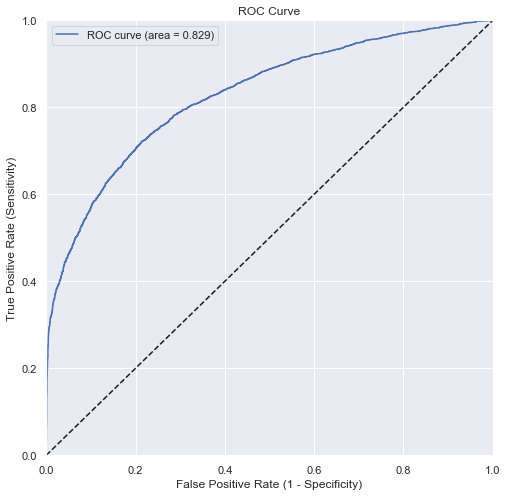

In [202]:
# calculate ROC-Curve
fpr, tpr, thresholds = roc_curve(testLabels, probabilities[:,1])
roc_auc = roc_auc_score(testLabels, probabilites[:,1])
# plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label="ROC curve (area = {:.3f})".format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
# styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=12)
plt.ylabel('True Positive Rate (Sensitivity)', size=12)
plt.title('ROC Curve', size=12)
plt.legend(loc='best');

### Analyze recall and precision for CHURN in more detail

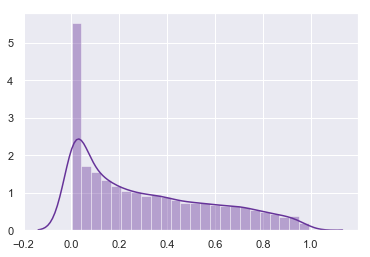

In [95]:
# quickcheck distribution of returned probabilities for an instance beeing classified as CHURN
sns.distplot(probabilites[:,0], color='rebeccapurple')
sns.title('Distribution of probabilities for predicting CHURN', size=12);

**Observation**: The model seems more confident in predicting with high probability which instances are ACTIVE than which are CHURN.

In [136]:
# combine probabilities for CHURN, predictions and testLabels in dataframe ordered by probability (highest)
finalResultsDF = pd.DataFrame({'proba': probabilities[:,0], 'pred' : predictions, 'label' : np.array(testLabels)}
                             ).sort_values('proba', ascending=False).reset_index().drop('index', axis=1)

In [138]:
# check
finalResultsDF.head(10)

,proba,pred,label
0,0.993316,0,0
1,0.991981,0,0
2,0.991305,0,0
3,0.989501,0,0
4,0.986740,0,0
5,0.985647,0,0
6,0.985459,0,1
7,0.984573,0,1
8,0.983488,0,0
9,0.981355,0,0


In [164]:
print("Number of CHURN predicted: {} ({:.2f}% from total)".format(
    finalResultsDF['pred'].value_counts()[0], (finalResultsDF['pred'].value_counts()[0]/len(finalResultsDF))*100))
print("Number of CHURN labeled: {}, ({:.2f}% from total)".format(
    finalResultsDF['label'].value_counts()[0], (finalResultsDF['label'].value_counts()[0]/len(finalResultsDF))*100))

Number of CHURN predicted: 2721 (26.46% from total)
Number of CHURN labeled: 3333, (32.41% from total)


**Observation**: The model predicts significantly less CHURN than is labeled in the data. The recall is low.

In [181]:
# calculate some metrics for different thresholds of predicted CHURN probabilty
probThresholds = np.arange(0.5, 1.0, 0.1)
for threshold in probThresholds:
    print("\nProbability threshold for CHURN prediction: {:.1f}%".format(threshold*100))
    df = finalResultsDF[finalResultsDF['proba'] >= threshold]
    print("Number of predictions in selection: {}".format(len(df)))
    print("Share of CHURN predictions: {:.2f}%".format((len(df)/finalResultsDF['pred'].value_counts()[0])*100))
    print("Share of all predictions: {:.2f}%".format((len(df)/len(finalResultsDF))*100))
    print("Number of ACTIVE in selection: {} ({:.2f}% of selection)".format(df['label'].sum(), (df['label'].sum()/len(df)*100)))


Probability threshold for CHURN prediction: 50.0%
Number of predictions in selection: 2721
Share of CHURN predictions: 100.00%
Share of all predictions: 26.46%
Number of ACTIVE in selection: 916 (33.66% of selection)

Probability threshold for CHURN prediction: 60.0%
Number of predictions in selection: 1985
Share of CHURN predictions: 72.95%
Share of all predictions: 19.30%
Number of ACTIVE in selection: 584 (29.42% of selection)

Probability threshold for CHURN prediction: 70.0%
Number of predictions in selection: 1303
Share of CHURN predictions: 47.89%
Share of all predictions: 12.67%
Number of ACTIVE in selection: 338 (25.94% of selection)

Probability threshold for CHURN prediction: 80.0%
Number of predictions in selection: 712
Share of CHURN predictions: 26.17%
Share of all predictions: 6.92%
Number of ACTIVE in selection: 167 (23.46% of selection)

Probability threshold for CHURN prediction: 90.0%
Number of predictions in selection: 273
Share of CHURN predictions: 10.03%
Share o

### Plot precision-recall curve

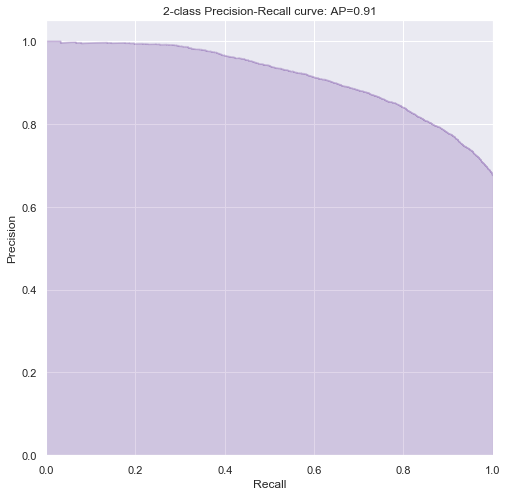

In [213]:
# calculate precision-recall curve
average_precision = average_precision_score(testLabels, probabilities[:,1])
precision, recall, thresholds = precision_recall_curve(
    testLabels, probabilities[:,1])
# plot precision-recall curve
plt.figure(figsize=(8,8))
plt.step(recall, precision, color='rebeccapurple', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='rebeccapurple')
# styling
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format( average_precision));

### Re-examine feature importances

In [29]:
xgbChurnImportances = xgbChurn.feature_importances_
print(xgbChurnImportances)

[5.14320206e-02 3.97054694e-02 6.37593795e-02 1.07433028e-01
 1.26070603e-01 4.31181051e-02 2.54946674e-01 3.27771784e-02
 3.55862234e-02 7.57222075e-02 1.73891906e-03 3.33023713e-03
 9.35620100e-04 1.02506550e-03 1.40965838e-03 1.03418082e-03
 2.25811605e-02 6.91910235e-04 5.97535736e-04 4.65126833e-04
 7.07790528e-04 7.96438626e-04 1.67726309e-04 2.02084134e-03
 1.17138692e-04 0.00000000e+00 8.94782094e-04 9.49467384e-04
 7.99422696e-04 5.13155908e-04 3.44680373e-05 8.25820951e-04
 1.87429743e-03 6.03499078e-04 9.03784022e-04 9.95629500e-04
 1.13753314e-03 1.26128349e-03 3.04485781e-04 8.55677740e-04
 7.05244812e-05 2.19209354e-04 1.21104756e-03 1.68722283e-03
 2.16495313e-04 8.45895280e-04 6.17574489e-04 9.67951393e-04
 8.23136324e-04 7.57775221e-04 6.35605733e-04 2.52019965e-04
 4.68290559e-05 4.56317918e-04 3.32353199e-04 5.62882363e-04
 7.15303453e-04 3.34982278e-04 2.48990369e-04 4.21385082e-04
 4.40333994e-05 5.85065414e-04 5.94689432e-04 9.41715954e-04
 3.35136273e-04 1.483668

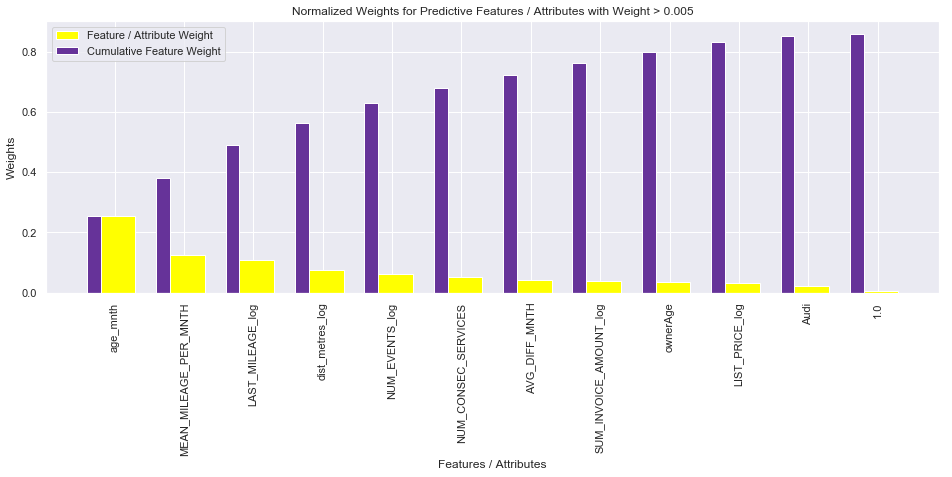

In [102]:
# reconstruct feature names (numCols) & one-hot-encoded-attribute names (catCols) for dimensions in test_prepared
encoderTest = fullPipelineTest.named_transformers_['encoder']
oneHotAttribs = []
for sublist in list(encoderTest.categories_):
    for item in sublist:
        oneHotAttribs.append(item)
attribs = numCols + oneHotAttribs
# zip feature names and importances
featureImportancesTest = (sorted(zip(xgbChurnImportances, attribs), reverse=True))
# create dataframe of featureImportancesTest, select features with biggest weights
dfPlot = pd.DataFrame(featureImportancesTest)
dfPlot = dfPlot[dfPlot[0] > 0.005]    
# plot features with biggest weight
fig = plt.figure(figsize = (16,5))
plt.bar(np.arange(len(dfPlot)), dfPlot[0], width = 0.6, align="center", color = 'yellow', \
      label = "Feature / Attribute Weight")
plt.bar(np.arange(len(dfPlot)) - 0.3, np.cumsum(dfPlot[0]), width = 0.2, align = "center", color = 'rebeccapurple', \
      label = "Cumulative Feature Weight")
# styling
plt.title("Normalized Weights for Predictive Features / Attributes with Weight > 0.005", fontsize = 12)
plt.ylabel("Weights", fontsize = 12)
plt.xlabel("Features / Attributes", fontsize = 12)
plt.xticks(np.arange(len(dfPlot)), dfPlot[1], rotation=90)
plt.legend(loc = 'upper left');

**Conclusions:**
- it is very interesting to see how many more of the features have got a weight > 0 (nearly all). That looked very different for the first Feature Importance calculation with the simple XGB model.
- It is also remarkable how the order of the most important features has changed. For example dist_metres is now less important than MEAN_MILEAGE and LAST_MILEAGE - it seems the more complex model has been able to exploit those latter features better than the simpler one.

## Back-up

In [ ]:
# old pipeline

df = train

numCols = list(df.select_dtypes(include = ['float64', 'int64']).columns)
catCols = list(df.select_dtypes(include = 'category').columns)

# make sure every value in all of the cat column is of the same dtype for the encoding - NaN removal has changed some objects 
for col in catCols:
    df[col] = df[col].astype(str)

numPipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

catPipeline = Pipeline([
    ('encoder', OneHotEncoder()),
])

fullPipeline = ColumnTransformer([
        ("num", numPipeline, numCols),
        ("cat", catPipeline, catCols),
    ])

train_prepared = fullPipeline.fit_transform(df)

In [ ]:
# # Create the RFE object and compute a cross-validated score
# logReg = LogisticRegression()
# rfecv = RFECV(estimator=logReg, step=1, cv=StratifiedKFold(2), scoring=make_scorer(fbeta_score, beta=0.5))
# rfecv.fit(train_prepared, trainLabels)

# print("Optimal number of features : %d" % rfecv.n_features_)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);

In [ ]:
# rfecv.support_

In [ ]:

# sorted(scores.keys())

# print(scores['test_score'])
# print("F-Beta: {:.2f} (+/- {:.2f})".format(np.mean(scores['test_score']), np.std(scores['test_score']) * 2))